**ANALYSIS OF ROAD ACCIDENTS IN YEKATERINBURG**

**Tasks:**
1. Analysis of historical data:
- dynamics of the number of accidents
- number of accidents by the time, season, severity, category, sex of the driver, driving experience, rayons

2. Visualization on the map
- number of accidents by rayons - choropleth
- all accidents in the city - heatmap
- for 2022 - map of the accidents by severity and by sex of the driver

**Data source**
- site of the non-commercial project "Map of road accidents" - https://dtp-stat.ru/opendata
- api open street maps

# Primary data preprocessing

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import requests
sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc={'figure.figsize':(15,5)} )
import requests
import json
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from pandas_geojson import write_geojson

We received a file in geojson format with accidents in all cities of the Sverdlovsk region. Filter the data and leave only Yekaterinburg

In [2]:
df = gpd.read_file('ekat.geojson')

In [3]:
df = df.query('region == "Екатеринбург"')

In [4]:
df.head()

,id,light,point,region,scheme,address,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,participants_count,geometry
7207,2614601,Светлое время суток,"{'lat': 56.903273, 'long': 60.598}",Екатеринбург,820,"г Екатеринбург, ул 40-летия Октября, 88",Наезд на пешехода,2021-08-26T15:10:00,Легкий,"[ { ""year"": 2020, ""brand"": ""TOYOTA"", ""color"": ...",0,"[ { ""role"": ""Пешеход"", ""gender"": ""Женский"", ""v...",1,Свердловская область,2,POINT (60.59800 56.90327)
7208,2614574,Светлое время суток,"{'lat': 56.858399, 'long': 60.655904}",Екатеринбург,710,"г Екатеринбург, ул Блюхера, 38",Наезд на пешехода,2021-08-26T09:00:00,Легкий,"[ { ""year"": 2012, ""brand"": ""FORD"", ""color"": ""Б...",0,"[ { ""role"": ""Пешеход"", ""gender"": ""Женский"", ""v...",1,Свердловская область,2,POINT (60.65590 56.85840)
7209,2614367,Светлое время суток,"{'lat': 56.848702, 'long': 60.627161}",Екатеринбург,840,"г Екатеринбург, ул Советская, 6 а",Наезд на пешехода,2021-08-25T16:30:00,Легкий,"[ { ""year"": 2008, ""brand"": ""ВАЗ"", ""color"": ""Че...",0,"[ { ""role"": ""Пешеход"", ""gender"": ""Мужской"", ""v...",1,Свердловская область,2,POINT (60.62716 56.84870)
7210,2614904,"В темное время суток, освещение включено","{'lat': 56.792101, 'long': 60.774736}",Екатеринбург,500,"г Екатеринбург, ул Карельская, 68а",Наезд на велосипедиста,2021-08-24T19:50:00,Легкий,"[ { ""year"": 2005, ""brand"": ""ВАЗ"", ""color"": ""Си...",0,[ ],1,Свердловская область,2,POINT (60.77474 56.79210)
7211,2617537,"В темное время суток, освещение включено","{'lat': 56.837782, 'long': 60.571918}",Екатеринбург,860,"г Екатеринбург, ул Пирогова, 4",Наезд на пешехода,2021-08-31T02:40:00,С погибшими,"[ { ""year"": 2004, ""brand"": ""ВАЗ"", ""color"": ""Се...",1,"[ { ""role"": ""Пешеход"", ""gender"": ""Женский"", ""v...",0,Свердловская область,2,POINT (60.57192 56.83778)


## Duplicates

We can not find full duplicates because some columns in our data contain dict object. Let's chack if we have duplicates by address and date

In [5]:
df.duplicated(['address', 'datetime']).sum()

0

## Missing values

In our data missing values look like "None"

In [6]:
df = df.replace('None', np.nan)

We remember that there are some dict in columns. For us it is very important to have coordinates of the road accident. Let's create columns with latitude and longitude and check if there are NaNs

In [7]:
df['long'] = df.point.apply(lambda x: x['long'])
df['lat'] = df.point.apply(lambda x: x['lat'])

In [8]:
df = df.replace('None', np.nan)

In [9]:
len(df.query('long.isna() or lat.isna()'))

0

All is ok with coordinates. Lets chack another columns

In [10]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8015 entries, 7207 to 15221
Data columns (total 18 columns):
id                    8015 non-null int64
light                 8015 non-null object
point                 8015 non-null object
region                8015 non-null object
scheme                7893 non-null object
address               7573 non-null object
category              8015 non-null object
datetime              8015 non-null object
severity              8015 non-null object
vehicles              8015 non-null object
dead_count            8015 non-null int64
participants          8015 non-null object
injured_count         8015 non-null int64
parent_region         8015 non-null object
participants_count    8015 non-null int64
geometry              8015 non-null geometry
long                  8015 non-null float64
lat                   8015 non-null float64
dtypes: float64(2), geometry(1), int64(4), object(11)
memory usage: 1.2+ MB


We don't care about Nans in scheme - we not gonna use it in out analysis. But let's try to fill in gaps for the addresses

In [11]:
len(df.query('address.isna()'))

442

Fill in the gaps with geopy by coordinates

In [12]:
#example
geolocator = Nominatim(user_agent="my-appln")
location = geolocator.reverse("56.853536, 60.615284")
print(location.address)

36, улица Луначарского, Малевич, Железнодорожный район, Екатеринбург, городской округ Екатеринбург, Свердловская область, Уральский федеральный округ, 620047, Россия


We pass a string with latitude and longitude separated by commas to the geolocator

In [13]:
df['lat_long'] = df['lat'].astype('str') + ',' + df['long'].astype('str')

In [14]:
def find_address(cell):
    return geolocator.reverse(cell)

In [15]:
missing_address = df.query('address.isna()')

In [16]:
missing_address['found_address'] = missing_address['lat_long'].apply(lambda x: geolocator.reverse(x))

C:\Users\Utilisateur\anaconda3\envs\praktikum_env_win_new1\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [17]:
df = df.merge(missing_address[['id', 'found_address']], on = 'id', how = 'left')

In [18]:
df.loc[df['address'].isna(), 'address'] = df.loc[df['address'].isna(), 'found_address']

In [19]:
df = df.drop('found_address', axis = 1)

# API openstreetmap

Since in the initial data we do not have a point belonging to a particular district of the city, as well as the data itself along the borders of the districts, we pull out the data from the outside.

## Rayons borders

To begin with, we create a list of districts existing in the city

In [20]:
ekat_rayons = ['Верх-Исетский', 'Железнодорожный', 'Кировский', 
               'Ленинский', 'Октябрьский', 'Орджоникидзевский', 'Чкаловский', 'Академический']

We work with API open street maps
- in the loop we refer to it for each district from the list we created
- passing the polygon_geojson=1 parameter, we say that we need the boundaries of this area
- transforming string into json 
- from this json we pull out the coordinates of the polygon - that is, the borders of the area 
- transforming the pulled out coordinates into a polygon using the shapely library
- create a table with the names of districts and their boundaries

In [21]:
lst_poly = []
for r in ekat_rayons:
    d = json.loads(requests.get(f"http://nominatim.openstreetmap.org/search?q={r} район Екатеринбург&polygon_geojson=1&format=json").text)[0]
    lst_sets = []
    for elem in d['geojson']['coordinates'][0]:
        lst_sets.append(tuple(elem))
    lst_poly.append(Polygon(lst_sets))
    

In [22]:
df_polygons = pd.DataFrame()

We've got some data from Internet about area and population for each rayon

In [23]:
df_polygons['rayon'] = ekat_rayons
df_polygons['geometry'] = lst_poly
df_polygons['area'] = [240, 126, 72, 25, 176, 102, 402, 25]
df_polygons['population'] = [241, 159, 221, 222, 152, 264, 286, 81]

In [24]:
df_polygons

,rayon,geometry,area,population
0,Верх-Исетский,"POLYGON ((60.0070815 56.8058752, 60.008038 56....",240,241
1,Железнодорожный,"POLYGON ((60.2605434 56.853676, 60.265983 56.8...",126,159
2,Кировский,"POLYGON ((60.6016526 56.8426176, 60.6022864 56...",72,221
3,Ленинский,"POLYGON ((60.5030286 56.7575283, 60.5041766 56...",25,222
4,Октябрьский,"POLYGON ((60.6056633 56.8274192, 60.6058334 56...",176,152
5,Орджоникидзевский,"POLYGON ((60.5075702 56.9172442, 60.5077477 56...",102,264
6,Чкаловский,"POLYGON ((60.1663538 56.7423799, 60.1698287 56...",402,286
7,Академический,"POLYGON ((60.3838205 56.8001734, 60.3840566 56...",25,81


## Point belonging to rayons

For each polygon and point (accident site), we check the entry of the point into the polygon

In [25]:
list_rayons = []
list_points = []
list_polygons = []
list_id = []
for i in range(len(df_polygons)):
    for j in range(len(df)):
        if df_polygons['geometry'][i].contains(df['geometry'][j]):
            list_rayons.append(df_polygons['rayon'][i]) 
            list_points.append(df['geometry'][j])
            list_polygons.append(df_polygons['geometry'][i])
            list_id.append(df['id'][j])

In [26]:
rayons_points = pd.DataFrame()
rayons_points['rayon'] = list_rayons
rayons_points['geometry_points'] = list_points
rayons_points['geometry_polygons'] = list_polygons
rayons_points['id'] = list_id

We merge our original table with the received one, getting for each point information about which rayon it belongs to

In [27]:
df = rayons_points.merge(df, on = 'id')

# Creating additional features

In [28]:
df['datetime'] = pd.to_datetime(df['datetime'], format = "%Y-%m-%dT%H:%M:%S")

In [29]:
df['year'] = df['datetime'].dt.year

In [30]:
df['number_month'] = df['datetime'].dt.month

In [31]:
df['time'] = df['datetime'].dt.hour

In [32]:
df['month'] = df['datetime'].astype('datetime64[M]')

In [33]:
def get_season(cell):
    if cell== 12 or cell ==1 or cell ==2:
        return 'winter'
    elif cell == 3 or cell ==4 or cell ==5:
        return 'spring'
    elif cell== 6 or cell ==7 or cell ==8:
        return 'summer'
    else: return 'automn'

In [34]:
df['season'] = df['number_month'].apply(get_season)

In [35]:
def get_stage(cell):
    try:
        return (json.loads(cell.replace("'", '"'))[0]['participants'][0]['years_of_driving_experience'])
    except: return np.nan

In [36]:
df['stage'] = df.vehicles.apply(get_stage).astype('Int64')

In [37]:
def get_sex(cell):
    try:
        return (json.loads(cell.replace("'", '"'))[0]['participants'][0]['gender'])
    except: return np.nan

In [38]:
df['sex'] = df.vehicles.apply(get_sex)

# Analysis of historical data

In [39]:
print(f'Analysis for the period  {df["datetime"].min()} - {df["datetime"].max()}')

Analysis for the period  2015-01-01 03:00:00 - 2022-10-31 22:30:00


In [40]:
def draw_plot(index, values, title, ylabel, kind):
    df.pivot_table(index = index, values = values, aggfunc = 'count').plot(kind = kind)
    plt.legend('')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('');

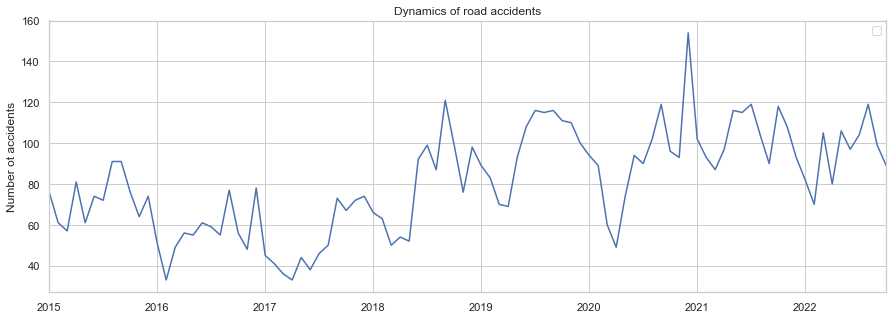

In [41]:
draw_plot('month', 'id', 'Dynamics of road accidents', 'Number ot accidents', 'line')

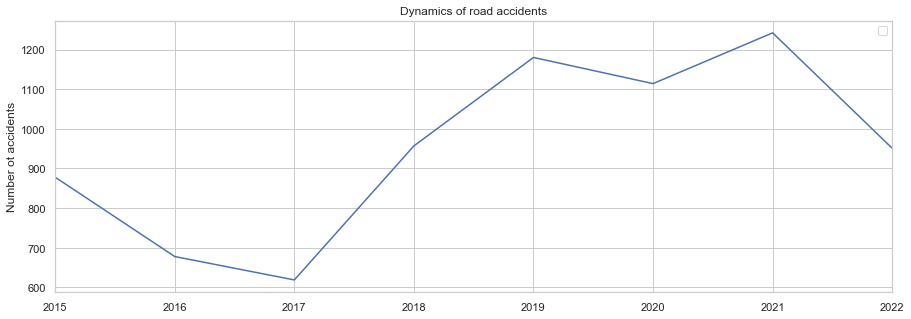

In [42]:
draw_plot('year', 'id', 'Dynamics of road accidents', 'Number ot accidents', 'line')

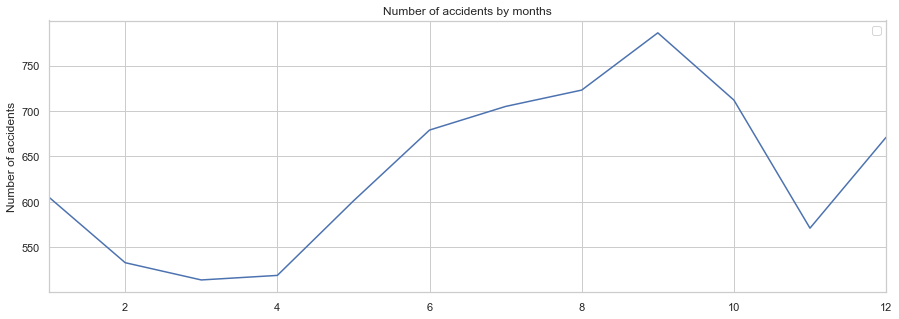

In [43]:
draw_plot('number_month', 'id', 'Number of accidents by months', 'Number of accidents', 'line')

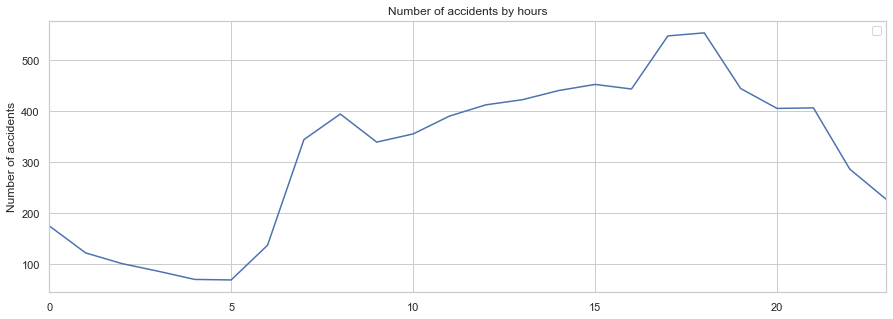

In [44]:
draw_plot('time', 'id', 'Number of accidents by hours', 'Number of accidents', 'line')

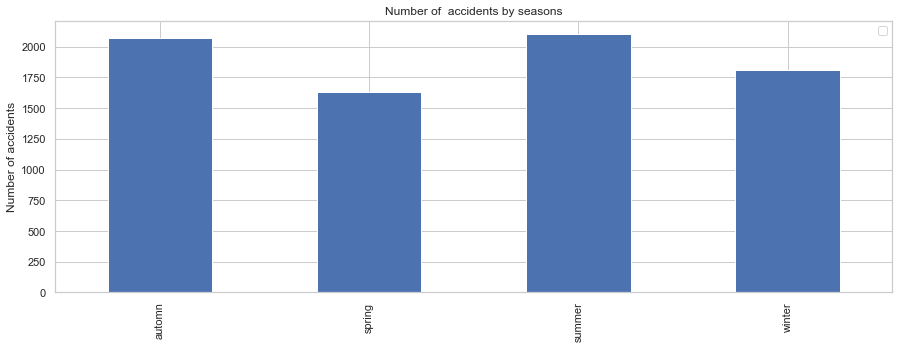

In [45]:
draw_plot('season', 'id', 'Number of  accidents by seasons', 'Number of accidents', 'bar')

**We see that the number of accidents is growing from year to year (except in 2020). Highest growth since 2017 - this is logical due to the growth in the number of drivers and cars**

**There is also a change in seasons - most accidents occur in summer and autumn - people are more likely to use their cars for vacation trips or for some extra activities**

**We record the maximum number of accidents from 4 pm to 7 pm - the time when people leave their jobs and the time of heavy traffic**

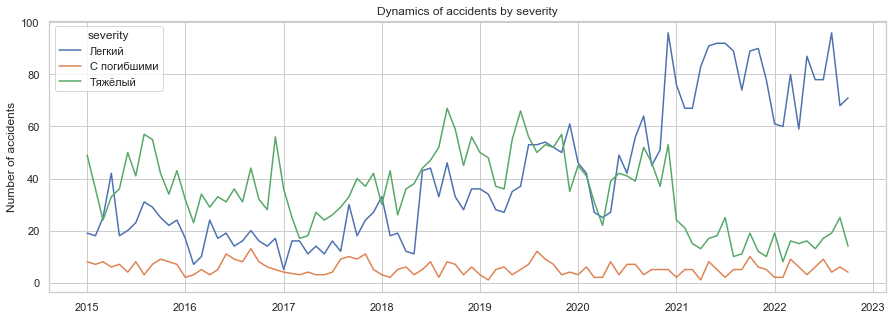

In [46]:
sns.lineplot(data =df.groupby(['month', 'severity'])['id'].count().reset_index(), x = 'month', y = 'id', hue = 'severity')
plt.title('Dynamics of accidents by severity')
plt.ylabel('Number of accidents')
plt.xlabel('');

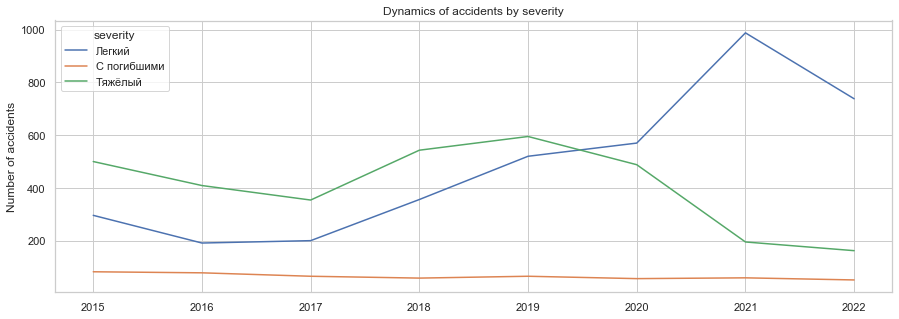

In [47]:
sns.lineplot(data =df.groupby(['year', 'severity'])['id'].count().reset_index(), x = 'year', y = 'id', hue = 'severity')
plt.title('Dynamics of accidents by severity')
plt.ylabel('Number of accidents')
plt.xlabel('');

**We see that since the middle of 2019, the majority of accidents ended without serious consequences and without a fatal outcome**

**In the period 2015-2019 most of the accidents were severe**

**The number of fatal accidents for the entire period remains unchanged. At the same time, since 2020, we have seen a rapid increase in accidents with minor consequences**

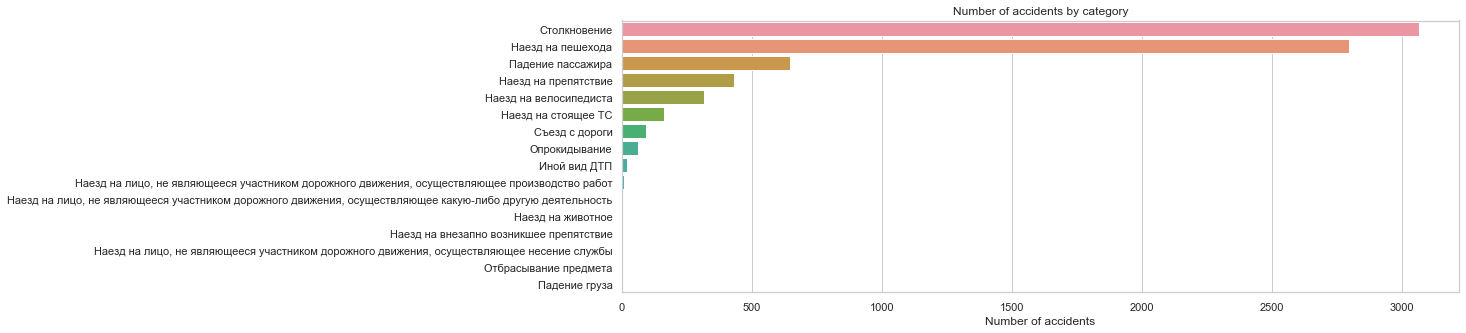

In [48]:
sns.barplot(data = df.groupby('category')['id'].count().reset_index().sort_values(by = 'id', ascending = False), x = 'id', y = 'category')
plt.title('Number of accidents by category')
plt.ylabel('')
plt.xlabel('Number of accidents');

**The most frequent accidents are collision and collision with a pedestrian**

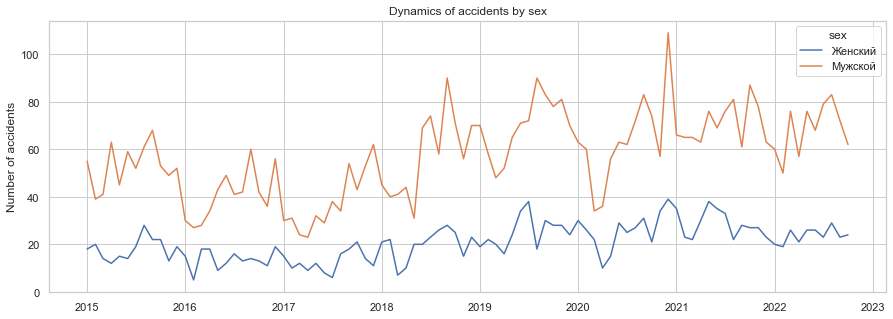

In [49]:
sns.lineplot(data =df.groupby(['month', 'sex'])['id'].count().reset_index(), x = 'month', y = 'id', hue = 'sex')
plt.title('Dynamics of accidents by sex')
plt.ylabel('Number of accidents')
plt.xlabel('');

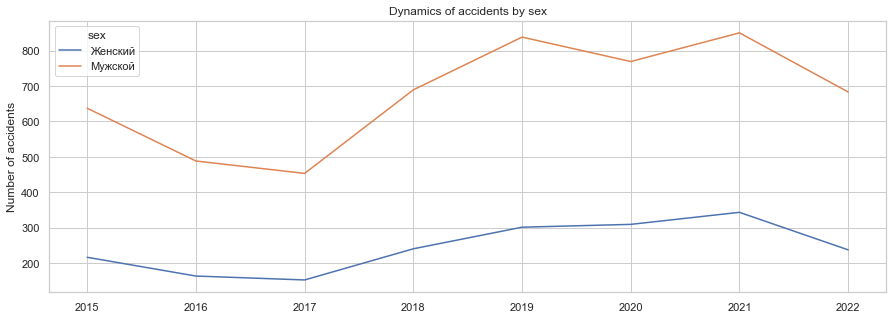

In [50]:
sns.lineplot(data =df.groupby(['year', 'sex'])['id'].count().reset_index(), x = 'year', y = 'id', hue = 'sex')
plt.title('Dynamics of accidents by sex')
plt.ylabel('Number of accidents')
plt.xlabel('');

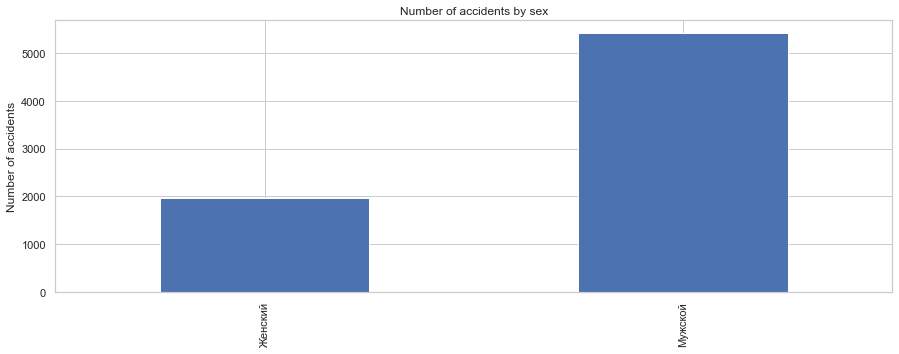

In [51]:
df.groupby('sex')['id'].count().plot(kind = 'bar')
plt.title('Number of accidents by sex')
plt.ylabel('Number of accidents')
plt.xlabel('');

**We observe almost identical dynamics for men and women. At the same time, there are much more male drivers involved in an accident (2.5 times)**

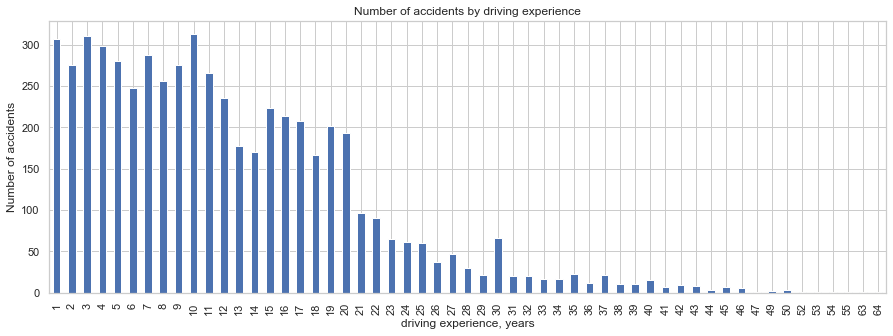

In [52]:
df.groupby('stage')['id'].count().plot(kind = 'bar')
plt.title('Number of accidents by driving experience')
plt.ylabel('Number of accidents')
plt.xlabel('driving experience, years');

**The vast majority of drivers have driving experience up to 12 years**

**Interestingly, the data includes a driver with 64 years of driving experience.**

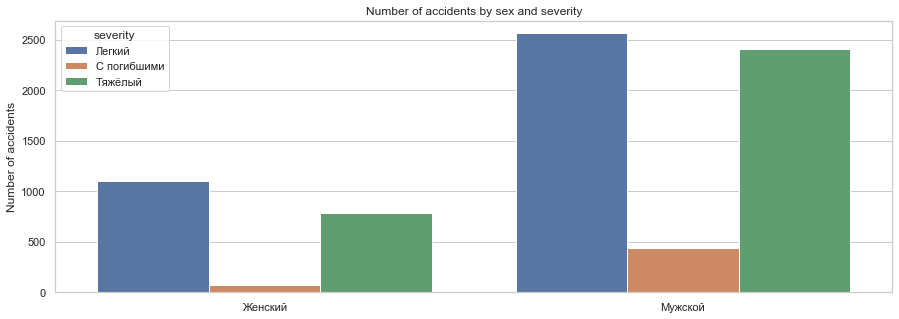

In [53]:
sns.barplot(data = df.groupby(['sex', 'severity'])['id'].count().reset_index(), x = 'sex', y = 'id', hue = 'severity')
plt.title('Number of accidents by sex and severity')
plt.ylabel('Number of accidents')
plt.xlabel('');

**Women are less likely to be involved in fatal crashes and accidents with hard severity than men.**

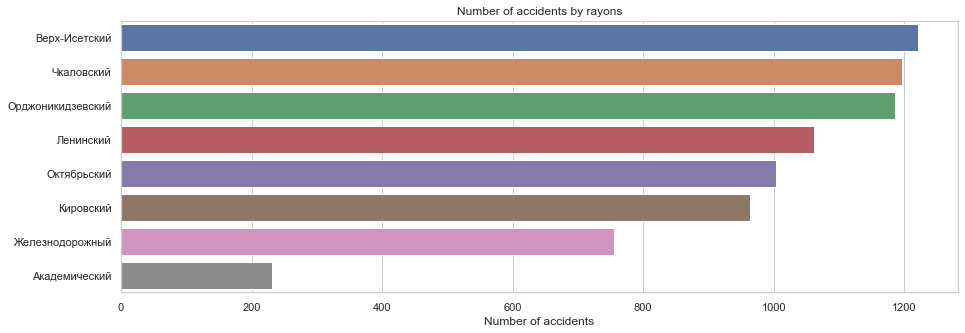

In [54]:
sns.barplot(data = df.groupby('rayon')['id'].count().reset_index().sort_values(by = 'id', ascending = False), x = 'id', y = 'rayon')
plt.title('Number of accidents by rayons')
plt.ylabel('')
plt.xlabel('Number of accidents');

In [55]:
df_polygons

,rayon,geometry,area,population
0,Верх-Исетский,"POLYGON ((60.0070815 56.8058752, 60.008038 56....",240,241
1,Железнодорожный,"POLYGON ((60.2605434 56.853676, 60.265983 56.8...",126,159
2,Кировский,"POLYGON ((60.6016526 56.8426176, 60.6022864 56...",72,221
3,Ленинский,"POLYGON ((60.5030286 56.7575283, 60.5041766 56...",25,222
4,Октябрьский,"POLYGON ((60.6056633 56.8274192, 60.6058334 56...",176,152
5,Орджоникидзевский,"POLYGON ((60.5075702 56.9172442, 60.5077477 56...",102,264
6,Чкаловский,"POLYGON ((60.1663538 56.7423799, 60.1698287 56...",402,286
7,Академический,"POLYGON ((60.3838205 56.8001734, 60.3840566 56...",25,81


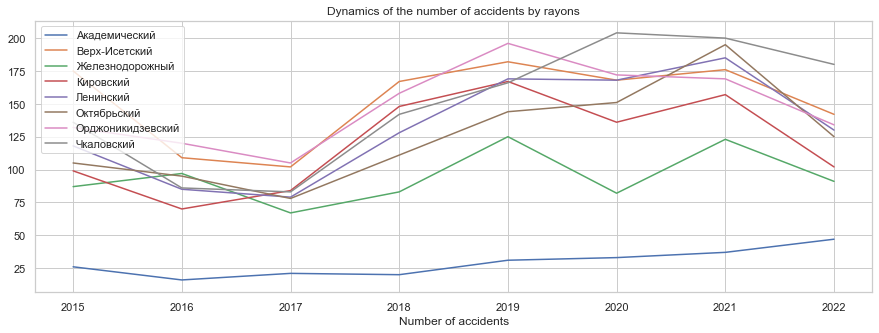

In [56]:
sns.lineplot(data = df.groupby(['rayon', 'year'])['id'].count().reset_index(), x = 'year', y = 'id', hue = 'rayon')
plt.legend(loc='upper left')
plt.title('Dynamics of the number of accidents by rayons')
plt.ylabel('')
plt.xlabel('Number of accidents');

**In the TOP 3 rayons by the total number of accidents - the largest districts in terms of area and population**

**For all districts except Oktyabrsky and Zheleznodorozhny, stagnation or a very slight change in indicators for 2020-2021 is observed. For the mentioned areas, there is a significant increase in the number of accidents.**

In [57]:
accidents_by_area = df.groupby('rayon')['id'].count().reset_index().merge(df_polygons[['rayon', 'area']], on = 'rayon')

In [58]:
accidents_by_area['accident_by_km2'] = accidents_by_area['id']/accidents_by_area['area']

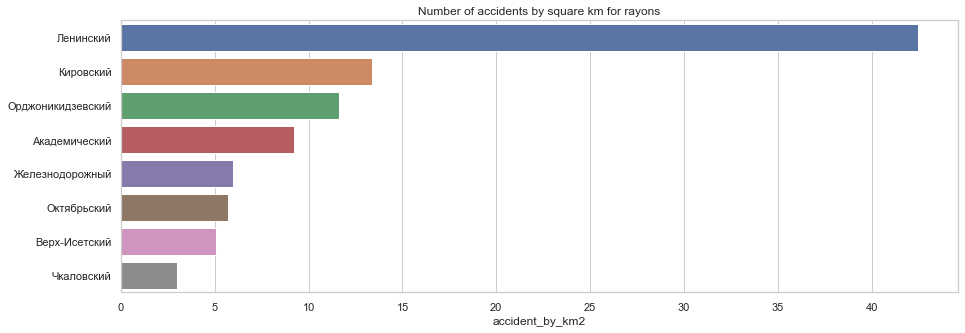

In [59]:
sns.barplot(data = accidents_by_area.sort_values(by = 'accident_by_km2', ascending = False), x = 'accident_by_km2', y = 'rayon')
plt.title('Number of accidents by square km for rayons')
plt.ylabel('');

In [60]:
d = df.merge(df_polygons, on = 'rayon').groupby(['rayon', 'area', 'year'])['id'].count().reset_index()

In [61]:
d['accident_by_km2'] = d['id']/d['area']

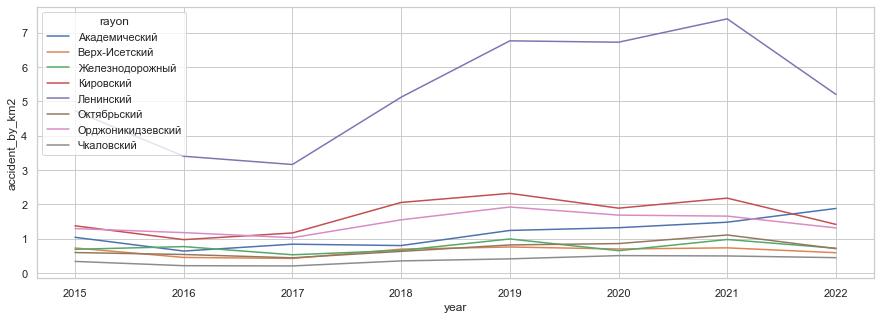

In [62]:
sns.lineplot(data =d, x = 'year', y = 'accident_by_km2', hue = 'rayon');

**If we count the number of accidents per square kilometer, then the TOP rayons change. And the worst rayon is the busiest downtown**

# Maps of road accidents

## Maps of all accidents

The simpliest map - heatmap. We also include rayons borders and pop-ups with the name of the rayon and the total number of accident

In [63]:
rayons_viz = df.groupby('rayon')['id'].count().reset_index().merge(df[['geometry_polygons', 'rayon']], on = 'rayon').drop_duplicates(['rayon'])

In [64]:
from folium.plugins import HeatMap
m = folium.Map(location=[56.8519, 60.6122], zoom_start = 9)
# drawing heatmap
lat = df.lat.tolist()
lng = df.long.tolist()
HeatMap(list(zip(lat, lng))).add_to(m)

# drawing borders of rayons
for _, r in rayons_viz.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    geo = gpd.GeoSeries(r['geometry_polygons']).simplify(tolerance=0.001)
    geojson = geo.to_json()
    geojson = folium.GeoJson(data=geojson)
   
    
    # creating popup with the name of the rayon and the total number of accidents for the last 7 years
    folium.Popup(str(r['rayon']) +': ' + str(r['id']) + ' accidents for all period').add_to(geojson)
    geojson.add_to(m)


m

Now we gonna create Choropleth. For this
1. We need to create geojson with all borders af rayons - after we gonna use it as the parameter geodata
2. Create the dataframe with names of rayons and the number of accidents 
3. In geojson each polygon has its own id which has to correspond with first column in list of columns (index)

In [65]:
rayons_viz = rayons_viz.reset_index(drop = True).reset_index()
rayons_viz['index'] = rayons_viz['index'].astype('str')

In [66]:
#geo = gpd.GeoSeries(rayons_viz['geometry_polygons']).simplify(tolerance=0.001)
#geo_j = geo.to_json()
#write_geojson(json.loads(geo_j), filename='ekat_rayons.geojson', indent=4)

In [67]:
m = folium.Map(location=[56.8519, 60.6122], zoom_start = 9)
folium.Choropleth(
    
    #loading geojson with polygons
    geo_data='ekat_rayons.geojson',
    name='choropleth',
    
    #loading dataframe with names of columns, the number of accidents for each rayon
    #also we create column 'index' corresponds to "id" in each geojson dictionary
    data=rayons_viz,
    
    #first column - column "to merge" with geojson, second -the value on which the color of the polygon depends
    columns=['index', 'id'],
    
    #feature from geojson "to merge" with data
    key_on='feature.id',
    
    ill_color='YlOrRd',
            nan_fill_color="White", #Use white color if there is no data available for the county
            fill_opacity=5,
            line_opacity=0.5,
            legend_name='Number of accidents', #title of the legend
            highlight=True,
            line_color='black'
).add_to(m)

# drawing borders of rayons
for _, r in rayons_viz.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    geo = gpd.GeoSeries(r['geometry_polygons']).simplify(tolerance=0.001)
    geojson = geo.to_json()
    geojson = folium.GeoJson(data=geojson)
   
    
    # creating popup with the name of the rayon and the total number of accidents for the last 7 years
    folium.Popup(str(r['rayon']) +': ' + str(r['id']) + ' accidents for all period').add_to(geojson)
    geojson.add_to(m)
m

And here map with clusters and layers for different months

In [68]:
from folium.plugins import MarkerCluster
m = folium.Map(location=[56.8519, 60.6122], zoom_start = 6)
mCluster1 = MarkerCluster(name = "Jul 2022").add_to(m)
lat1 = df.query('number_month == 7 and year == 2022')['lat'].tolist()
lng1 = df.query('number_month ==7 and year == 2022').long.tolist()
location1 = list(zip(lat1, lng1))
for point in range(0, len(location1)):
    folium.Marker(location1[point]).add_to(mCluster1)

mCluster2 = MarkerCluster(name = "Aug 2022").add_to(m)
lat2 = df.query('number_month ==8 and year == 2022').lat.tolist()
lng2 = df.query('number_month ==8 and year == 2022').long.tolist()
location2 = list(zip(lat2, lng2))
for point in range(0, len(location2)):
    folium.Marker(location2[point]).add_to(mCluster2)
    
mCluster3 = MarkerCluster(name = "Sep 2022").add_to(m)
lat3 = df.query('number_month ==9 and year == 2022').lat.tolist()
lng3 = df.query('number_month ==9 and year == 2022').long.tolist()
location3 = list(zip(lat3, lng3))
for point in range(0, len(location3)):
    folium.Marker(location3[point]).add_to(mCluster3)
    
mCluster4 = MarkerCluster(name = "Oct 2022").add_to(m)
lat4 = df.query('number_month ==10 and year == 2022').lat.tolist()
lng4 = df.query('number_month ==10 and year ==2022').long.tolist()
location4 = list(zip(lat4, lng4))
for point in range(0, len(location4)):
    folium.Marker(location4[point]).add_to(mCluster4)
folium.LayerControl(collapsed=True).add_to(m)
m

## Map of accidents 2022 by severity

In [69]:
rayons_viz_2022 = df.query('year == 2022').groupby(['rayon', 'severity'])['id'].count().reset_index()
rayons_viz_2022['severity_id'] = rayons_viz_2022['severity'] + ': ' + rayons_viz_2022['id'].astype('str')  + ' accidents'
to_merge = rayons_viz_2022.groupby('rayon')['severity_id'].unique().reset_index()
rayons_viz_2022_severity = to_merge.merge(df[['geometry_polygons', 'rayon']], on = 'rayon').drop_duplicates(['rayon'])
rayons_viz_2022_severity

,rayon,severity_id,geometry_polygons
0,Академический,"[Легкий: 40 accidents, Тяжёлый: 7 accidents]","POLYGON ((60.3838205 56.8001734, 60.3840566 56..."
231,Верх-Исетский,"[Легкий: 114 accidents, С погибшими: 6 acciden...","POLYGON ((60.0070815 56.8058752, 60.008038 56...."
1452,Железнодорожный,"[Легкий: 71 accidents, С погибшими: 3 accident...","POLYGON ((60.2605434 56.853676, 60.265983 56.8..."
2207,Кировский,"[Легкий: 84 accidents, С погибшими: 3 accident...","POLYGON ((60.6016526 56.8426176, 60.6022864 56..."
3170,Ленинский,"[Легкий: 115 accidents, С погибшими: 3 acciden...","POLYGON ((60.5030286 56.7575283, 60.5041766 56..."
4232,Октябрьский,"[Легкий: 88 accidents, С погибшими: 17 acciden...","POLYGON ((60.6056633 56.8274192, 60.6058334 56..."
5236,Орджоникидзевский,"[Легкий: 95 accidents, С погибшими: 8 accident...","POLYGON ((60.5075702 56.9172442, 60.5077477 56..."
6422,Чкаловский,"[Легкий: 131 accidents, С погибшими: 11 accide...","POLYGON ((60.1663538 56.7423799, 60.1698287 56..."


In [70]:
lat = list(df.query('year ==2022')["lat"])
lon = list(df.query('year ==2022')["long"])
severity = list(df.query('year ==2022')["severity"])
def color_producer(severity):
    if severity ==  'Легкий':
        return 'green'
    elif severity ==  'Тяжёлый':
        return 'orange'
    else:
        return 'red'

m = folium.Map(location=[56.8519, 60.6122], zoom_start=9)
sev = folium.FeatureGroup(name="Severity")

for lt, ln, severity in zip(lat, lon, severity):
    sev.add_child(folium.CircleMarker(location=[lt, ln], radius = 0.5, 
    fill_color=color_producer(severity), fill=True,  color = color_producer(severity), fill_opacity=0.7))
m.add_child(sev)

for _, r in rayons_viz_2022_severity.iterrows():

    geo = gpd.GeoSeries(r['geometry_polygons']).simplify(tolerance=0.001)
    geo_j = geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    
    folium.Popup(str(r['rayon']) +': ' + str(r['severity_id'] )).add_to(geo_j)
    geo_j.add_to(m)
m

## Map of accidents 2022 by sex of the driver

In [71]:
rayons_viz_2022 = df.query('year == 2022').groupby(['rayon', 'sex'])['id'].count().reset_index()
rayons_viz_2022['sex_id'] = rayons_viz_2022['sex'] + ': ' + rayons_viz_2022['id'].astype('str')  + ' accidents'
to_merge = rayons_viz_2022.groupby('rayon')['sex_id'].unique().reset_index()
rayons_viz_2022_sex = to_merge.merge(df[['geometry_polygons', 'rayon']], on = 'rayon').drop_duplicates(['rayon'])
rayons_viz_2022_sex

,rayon,sex_id,geometry_polygons
0,Академический,"[Женский: 11 accidents, Мужской: 34 accidents]","POLYGON ((60.3838205 56.8001734, 60.3840566 56..."
231,Верх-Исетский,"[Женский: 47 accidents, Мужской: 92 accidents]","POLYGON ((60.0070815 56.8058752, 60.008038 56...."
1452,Железнодорожный,"[Женский: 13 accidents, Мужской: 77 accidents]","POLYGON ((60.2605434 56.853676, 60.265983 56.8..."
2207,Кировский,"[Женский: 29 accidents, Мужской: 71 accidents]","POLYGON ((60.6016526 56.8426176, 60.6022864 56..."
3170,Ленинский,"[Женский: 44 accidents, Мужской: 79 accidents]","POLYGON ((60.5030286 56.7575283, 60.5041766 56..."
4232,Октябрьский,"[Женский: 21 accidents, Мужской: 102 accidents]","POLYGON ((60.6056633 56.8274192, 60.6058334 56..."
5236,Орджоникидзевский,"[Женский: 34 accidents, Мужской: 95 accidents]","POLYGON ((60.5075702 56.9172442, 60.5077477 56..."
6422,Чкаловский,"[Женский: 38 accidents, Мужской: 133 accidents]","POLYGON ((60.1663538 56.7423799, 60.1698287 56..."


In [72]:
lat = list(df.query('year ==2022')["lat"])
lon = list(df.query('year ==2022')["long"])
sex = list(df.query('year ==2022')['sex'])

def color_producer(sex):
    if sex ==  'Мужской':
        return 'blue'
    else:
        return 'red'


m = folium.Map(location=[56.8519, 60.6122], zoom_start=9)

s = folium.FeatureGroup(name="Sex")
for lt, ln, sex in zip(lat, lon, sex):
    s.add_child(folium.CircleMarker(location=[lt, ln], radius = 0.5, 
    fill_color=color_producer(sex), fill=True,  color = color_producer(sex), fill_opacity=0.7))
m.add_child(s)

for _, r in rayons_viz_2022_sex.iterrows():
    geo = gpd.GeoSeries(r['geometry_polygons']).simplify(tolerance=0.001)
    geo_j = geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    
    folium.Popup(str(r['rayon']) +': ' + str(r['sex_id'] )).add_to(geo_j)
    geo_j.add_to(m)
m